# Intensity recognition

|Activity intensity|  MET range  |
|------------------|-------------|
| Light            | < 3.00      |
| Moderate         | 3.00 - 5.99 |
| Hard             | 6.00 - 8.99 |
| Very hard        | > 8.99      |

Activty count cut-points bu : Freedson et al.(1998)

In [98]:
from helpers                 import pandas_helper as pdh, math_helper as mth
from utils                   import read_functions
from sensors.activpal        import *
from sensors.vyntus          import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import pandas            as pd

activpal = Activpal()
vyntus = Vyntus()

respondents_df = pdh.read_csv_respondents()

# Preparing dataset

In [80]:
def get_vyntus_df(correspondent, start, stop):   
    intensity_intervals = [0, 3, 5.99, 8.99, 1000]
    intensity_labels    = ['Light', 'Moderate', 'Hard', 'Very Hard']
    
    vyntus_df = vyntus.read_data(correspondent, start, stop)
    if vyntus_df.empty:
        return pd.DataFrame()
    
    corr_number = int(correspondent.replace('BMR0', '')) 
    
    weight = respondents_df['gewicht'][corr_number]

    vyntus_df['vyn_VO2'] = [float(vo2.replace(',', '.')) if type(vo2) == str else vo2 for vo2 in vyntus_df['vyn_VO2']]
    vyntus_df['met'] = mth.calculate_met(vyntus_df['vyn_VO2'], weight)    
    vyntus_df['weight'] = weight
    
    vyntus_df =  vyntus_df.resample('60s').mean()[:-1]
    
    vyntus_df['intensity'] = pd.cut(vyntus_df.met, intensity_intervals, labels=intensity_labels)
    
    return vyntus_df;

In [81]:
def get_activpal_df(correspondent, start, stop):
    activpal_df = activpal.read_data(correspondent, start, stop)
    
    activpal_df = activpal_df[['pal_accX', 'pal_accY', 'pal_accZ']].apply(mth.convert_value_to_g)
    
    x_abs = abs(activpal_df['pal_accX'])
    y_abs = abs(activpal_df['pal_accY'])
    z_abs = abs(activpal_df['pal_accZ'])
    
    activpal_df['mag_acc'] = mth.to_mag_acceleration(x_abs, y_abs, z_abs)
    
    return activpal_df.resample('60s').sum()[:-1]

In [82]:
def get_dataset_of_correspondent(correspondent):
    dataset_df = pd.DataFrame(columns=['sum_mag_of_acc', 'mean_met', 'intensity', 'activity'], index=pd.to_datetime([]))
    activities          = ['lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']
    
    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)

    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        
        if not activity.empty:
            
            start_time = activity.start
            stop_time = activity.stop
            
            activpal_df = get_activpal_df(correspondent, start_time, stop_time)
            vyntus_df = get_vyntus_df(correspondent, start_time, stop_time)
            
            if not vyntus_df.empty and not activpal_df.empty:
                activity_dataset_df = pd.DataFrame(index=activpal_df.index)

                activity_dataset_df['mean_met']       = vyntus_df['met']
                activity_dataset_df['sum_mag_of_acc'] = activpal_df['mag_acc']
                activity_dataset_df['weight']         = vyntus_df['weight']
                activity_dataset_df['intensity']      = vyntus_df['intensity']
                activity_dataset_df['activity']       = activity_name            
                
                activity_dataset_df.dropna(how='any', inplace=True)
                
                dataset_df = pd.concat([activity_dataset_df, dataset_df])
        
    return dataset_df   

In [83]:
def create_dataset_from_all_correspondents():
    dataset_df = pd.DataFrame(index=pd.to_datetime([]))

    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            for respDirect in directory[1]:
                if respDirect not in ['output', 'throughput', 'Test data','.ipynb_checkpoints', 'BMR025', 'BMR035', 'BMR100', 'BMR051', 'BMR027']:
                    print("Extracting " + respDirect)
                    correspondent_dataset_df = get_dataset_of_correspondent(respDirect)
                    dataset_df = pd.concat([dataset_df, correspondent_dataset_df])

    print("Done creating dataset")

    return dataset_df

In [84]:
dataset = create_dataset_from_all_correspondents()

Extracting BMR099
Extracting BMR060
No data for respondnet: BMR060
No data for respondnet: BMR060
No data for respondnet: BMR060
No data for respondnet: BMR060
No data for respondnet: BMR060
No data for respondnet: BMR060
Extracting BMR012
Extracting BMR030
Extracting BMR044
Extracting BMR043
Extracting BMR004
Extracting BMR011
Extracting BMR098
Extracting BMR034
Extracting BMR014
Extracting BMR036
Extracting BMR052
Extracting BMR002
Extracting BMR031
Extracting BMR097
Extracting BMR008
Extracting BMR015
Extracting BMR033
Extracting BMR064
Extracting BMR055
Extracting BMR041
Extracting BMR053
Extracting BMR042
Extracting BMR018
Extracting BMR058
Extracting BMR040
Extracting BMR032
Done creating dataset


## Dataset analysis

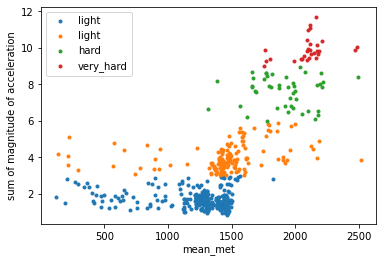

In [85]:
def plot_intensity_on_accel(dataset):
    light = dataset.loc[(dataset['intensity'] == 'Light') ]
    moderate = dataset.loc[(dataset['intensity'] == 'Moderate') ]
    hard = dataset.loc[(dataset['intensity'] == 'Hard') ]
    very_hard = dataset.loc[(dataset['intensity'] == 'Very Hard') ]
    
    plt.scatter(light['sum_mag_of_acc'],     light['mean_met'],    marker='.', label='light')
    plt.scatter(moderate['sum_mag_of_acc'],  moderate['mean_met'], marker='.', label='light')
    plt.scatter(hard['sum_mag_of_acc'],      hard['mean_met'],     marker='.', label='hard')
    plt.scatter(very_hard['sum_mag_of_acc'], very_hard['mean_met'],marker='.', label='very_hard')


    plt.xlabel('mean_met')
    plt.ylabel('sum of magnitude of acceleration')
    plt.legend()
    plt.show()

plot_intensity_on_accel(dataset)

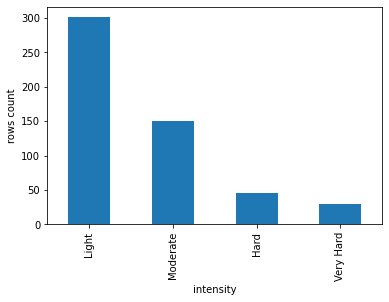

In [86]:
dataset['intensity'].value_counts().plot.bar(ylabel='rows count',xlabel='intensity')

## Defining categories

In [87]:
intensity_columns          = ['intensity_light', 'intensity_moderate', 'intensity_hard', 'intensity_very_hard']
dataset[intensity_columns] = 0

dataset.loc[(dataset['intensity'] == 'Light'),    'intensity_light']       = 1
dataset.loc[(dataset['intensity'] == 'Moderate'), 'intensity_moderate']    = 1
dataset.loc[(dataset['intensity'] == 'Hard'),     'intensity_hard']        = 1
dataset.loc[(dataset['intensity'] == 'Very Hard'),'intensity_very_hard']   = 1

dataset.dropna(how='any', inplace=True)

dataset.head()

,mean_met,sum_mag_of_acc,weight,intensity,activity,intensity_light,intensity_moderate,intensity_hard,intensity_very_hard
2019-09-12 10:38:00,1.658801,977.310095,64.0,Light,zitten,1,0,0,0
2019-09-12 10:39:00,1.505580,1429.448879,64.0,Light,zitten,1,0,0,0
2019-09-12 10:40:00,1.548363,1419.886845,64.0,Light,zitten,1,0,0,0
2019-09-12 10:41:00,1.508185,1419.545634,64.0,Light,zitten,1,0,0,0
2019-09-12 10:42:00,1.438616,1426.501272,64.0,Light,zitten,1,0,0,0


## Splitting dataset

In [88]:
x = dataset[['sum_mag_of_acc', 'weight']]
y = dataset[intensity_columns]

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state=23, stratify=y)

len(x)

526

## Training dataset

In [106]:
rfc = RandomForestClassifier(n_estimators=115,random_state=0)
rfc.fit(train_x, train_y)

RandomForestClassifier(n_estimators=115, random_state=0)

In [107]:
prediction_y = rfc.predict(valid_x)

## Result analysis

In [108]:
accuracy_score(valid_y, prediction_y, normalize=True)

0.8018867924528302

In [109]:
print(classification_report(valid_y, prediction_y, target_names=intensity_columns, zero_division=0))

                     precision    recall  f1-score   support

    intensity_light       0.86      0.92      0.89        61
 intensity_moderate       0.79      0.63      0.70        30
     intensity_hard       0.57      0.44      0.50         9
intensity_very_hard       0.60      1.00      0.75         6

          micro avg       0.80      0.80      0.80       106
          macro avg       0.71      0.75      0.71       106
       weighted avg       0.80      0.80      0.80       106
        samples avg       0.80      0.80      0.80       106



## Tune hyperparameteres

In [103]:
#### Quick analysis
accuracy_scores = []
f1_scores = []
#precision_scores = []

n_estimator_numbers = range(1,300)

for i in n_estimator_numbers:
    rfc_t = RandomForestClassifier(n_estimators=i, random_state=0)
    rfc_t.fit(train_x, train_y)
    
    predictions = rfc_t.predict(valid_x)
    
    accuracy_scores.append(accuracy_score(valid_y, predictions, normalize=True))
    f1_scores.append(f1_score(valid_y, predictions, average='micro' ))
    #precision_scores.append(precision_score(valid_y, predictions, average='micro'))

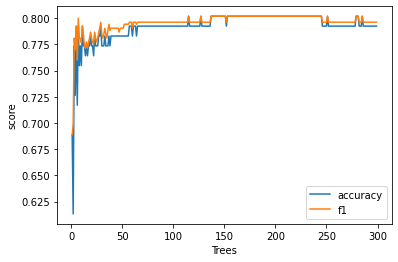

In [104]:
plt.plot(n_estimator_numbers, accuracy_scores, label='accuracy')
plt.plot(n_estimator_numbers, f1_scores, label='f1')

plt.xlabel('Trees')
plt.ylabel('score')
#plt.plot(n_estimator_numbers, precision_scores, label='precision')

plt.legend()

In [105]:
np_accuracy_scores = np.array(accuracy_scores)
np_f1_scores = np.array(f1_scores)

best_accuracy_index = np.argmax(np_accuracy_scores)
best_f1_index = np.argmax(np_f1_scores)

print('accuracy: ', n_estimator_numbers[best_accuracy_index])
print('f1: ', n_estimator_numbers[best_f1_index])

accuracy:  115
f1:  115
